<a href="https://colab.research.google.com/github/Sravya0901/SDCar/blob/main/Self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Sravya0901/SDCar.git

Cloning into 'SDCar'...
remote: Enumerating objects: 1754, done.
remote: Total 1754 (delta 0), reused 0 (delta 0), pack-reused 1754
Receiving objects: 100% (1754/1754), 116.47 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (1741/1741), done.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dir = "/content/SDCar"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(dir, "/content/SDCar/driving_log.csv"), names=columns)
pd.set_option("display.max_colwidth", -1)
data.head()

center  \
0  C:\Users\sravy\Downloads\simulator-windows-64\IMG\center_2023_05_27_17_00_46_767.jpg   
1  C:\Users\sravy\Downloads\simulator-windows-64\IMG\center_2023_05_27_17_00_46_908.jpg   
2  C:\Users\sravy\Downloads\simulator-windows-64\IMG\center_2023_05_27_17_00_47_041.jpg   
3  C:\Users\sravy\Downloads\simulator-windows-64\IMG\center_2023_05_27_17_00_47_174.jpg   
4  C:\Users\sravy\Downloads\simulator-windows-64\IMG\center_2023_05_27_17_00_47_323.jpg   

                                                                                  left  \
0   C:\Users\sravy\Downloads\simulator-windows-64\IMG\left_2023_05_27_17_00_46_767.jpg   
1   C:\Users\sravy\Downloads\simulator-windows-64\IMG\left_2023_05_27_17_00_46_908.jpg   
2   C:\Users\sravy\Downloads\simulator-windows-64\IMG\left_2023_05_27_17_00_47_041.jpg   
3   C:\Users\sravy\Downloads\simulator-windows-64\IMG\left_2023_05_27_17_00_47_174.jpg   
4   C:\Users\sravy\Downloads\simulator-windows-64\IMG\left_2023_05_27_17_00_47_323.jpg   

                                                                                  right  \
0   C:\Users\sravy\Downloads\simulator-windows-64\IMG\right_2023_05_27_17_00_46_767.jpg   
1   C:\Users\sravy\Downloads\simulator-windows-64\IMG\right_2023_05_27_17_00_46_908.jpg   
2   C:\Users\sravy\Downloads\simulator-windows-64\IMG\right_2023_05_27_17_00_47_041.jpg   
3   C:\Users\sravy\Downloads\simulator-windows-64\IMG\right_2023_05_27_17_00_47_174.jpg   
4   C:\Users\sravy\Downloads\simulator-windows-64\IMG\right_2023_05_27_17_00_47_323.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0        0.000081  
1  0.0       0.0       0        0.000078  
2  0.0       0.0       0        0.000079  
3  0.0       0.0       0        0.000079  
4  0.0       0.0       0        0.000081

In [ ]:
def pathleaf(path):
    head, tail = ntpath.split(path)
    return tail

data["center"] = data["center"].apply(pathleaf)
data["left"] = data["left"].apply(pathleaf)
data["right"] = data["right"].apply(pathleaf)
data.head()

center                              left  \
0  center_2023_05_27_17_00_46_767.jpg  left_2023_05_27_17_00_46_767.jpg   
1  center_2023_05_27_17_00_46_908.jpg  left_2023_05_27_17_00_46_908.jpg   
2  center_2023_05_27_17_00_47_041.jpg  left_2023_05_27_17_00_47_041.jpg   
3  center_2023_05_27_17_00_47_174.jpg  left_2023_05_27_17_00_47_174.jpg   
4  center_2023_05_27_17_00_47_323.jpg  left_2023_05_27_17_00_47_323.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2023_05_27_17_00_46_767.jpg  0.0       0.0       0        0.000081  
1  right_2023_05_27_17_00_46_908.jpg  0.0       0.0       0        0.000078  
2  right_2023_05_27_17_00_47_041.jpg  0.0       0.0       0        0.000079  
3  right_2023_05_27_17_00_47_174.jpg  0.0       0.0       0        0.000079  
4  right_2023_05_27_17_00_47_323.jpg  0.0       0.0       0        0.000081

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data["steering"], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


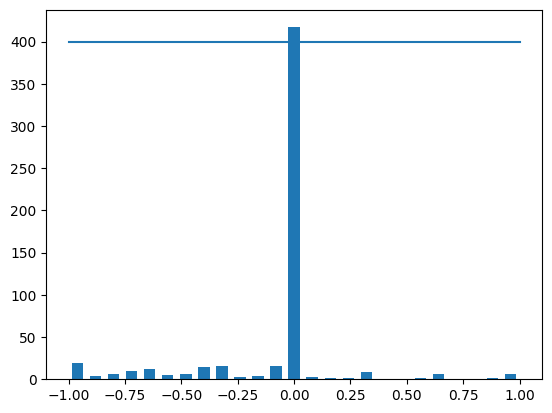

In [ ]:
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [ ]:
print("Total Data:", len(data))

Total Data: 561


In [ ]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print("Removed:", len(remove_list))

Removed: 17


In [ ]:
data.drop(data.index[remove_list], inplace=True)
print("Remaining:", len(data))

Remaining: 544


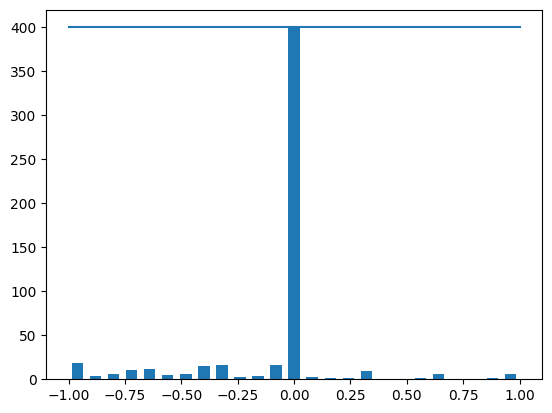

In [ ]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [ ]:
print(data.iloc[1])

center      center_2023_05_27_17_00_46_908.jpg
left        left_2023_05_27_17_00_46_908.jpg  
right       right_2023_05_27_17_00_46_908.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0                                 
speed       0.000078                          
Name: 1, dtype: object


In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

 # image_paths, steerings = load_img_steering(datadir + '../input/udacity-self-driving-car-behavioural-cloning/self_driving_car_dataset_make/IMG', data)

In [ ]:
image_paths, steerings = load_img_steering(dir + "/IMG", data)
X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=6
)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 1305
Valid Samples: 327


Text(0.5, 1.0, 'Validation set')

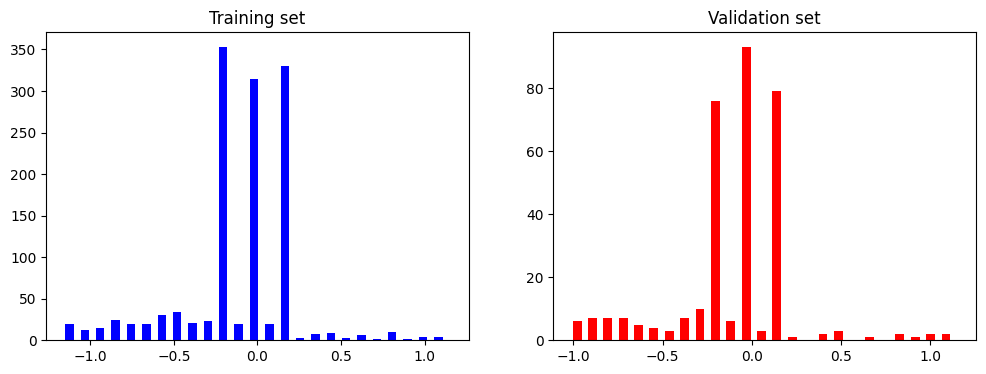

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title("Validation set")

Text(0.5, 1.0, 'Zoomed Image')

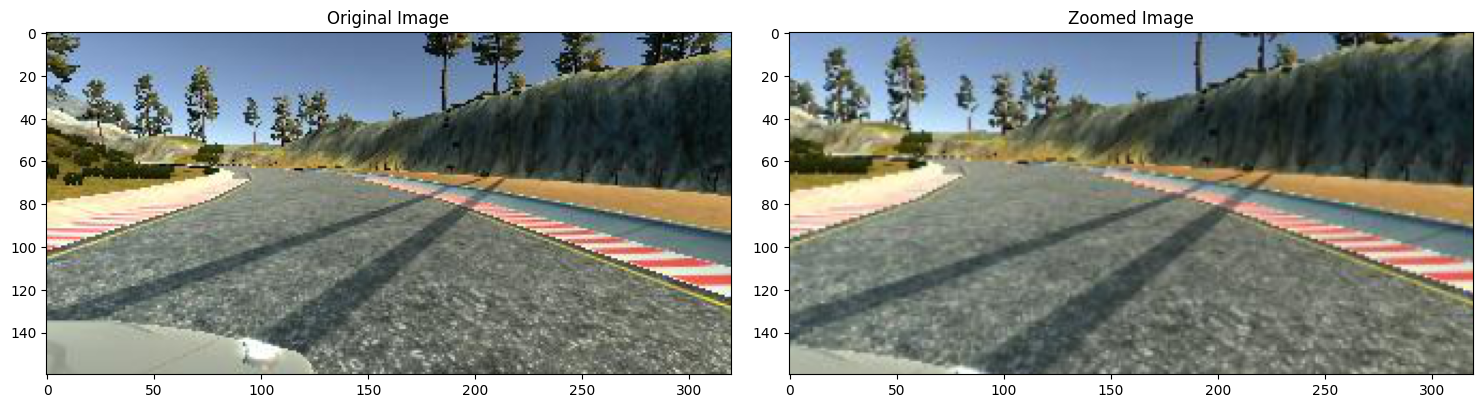

In [ ]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

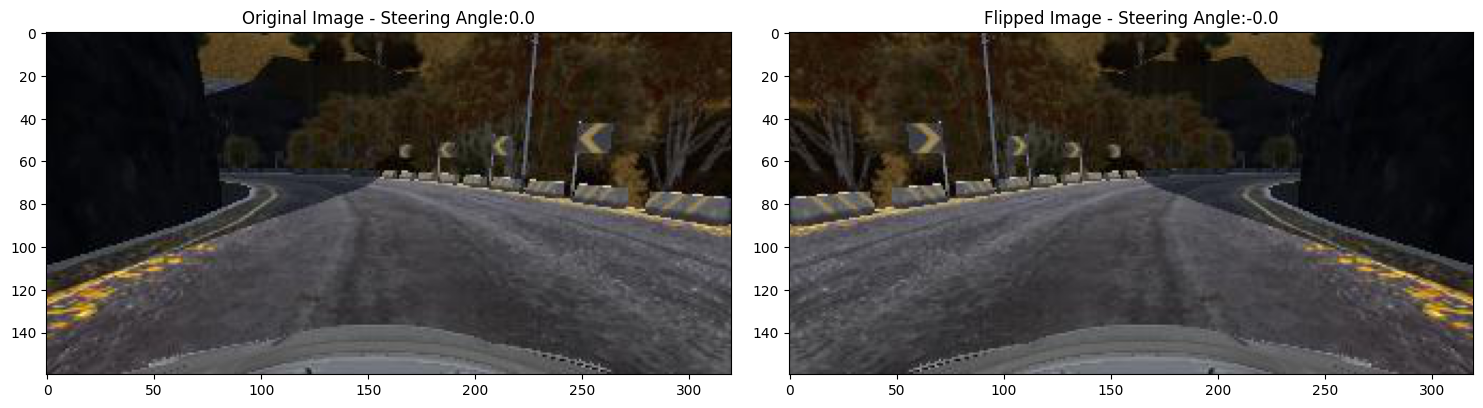

In [ ]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image - " + "Steering Angle:" + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title("Flipped Image - " + "Steering Angle:" + str(flipped_steering_angle))

Text(0.5, 1.0, 'Panned Image')

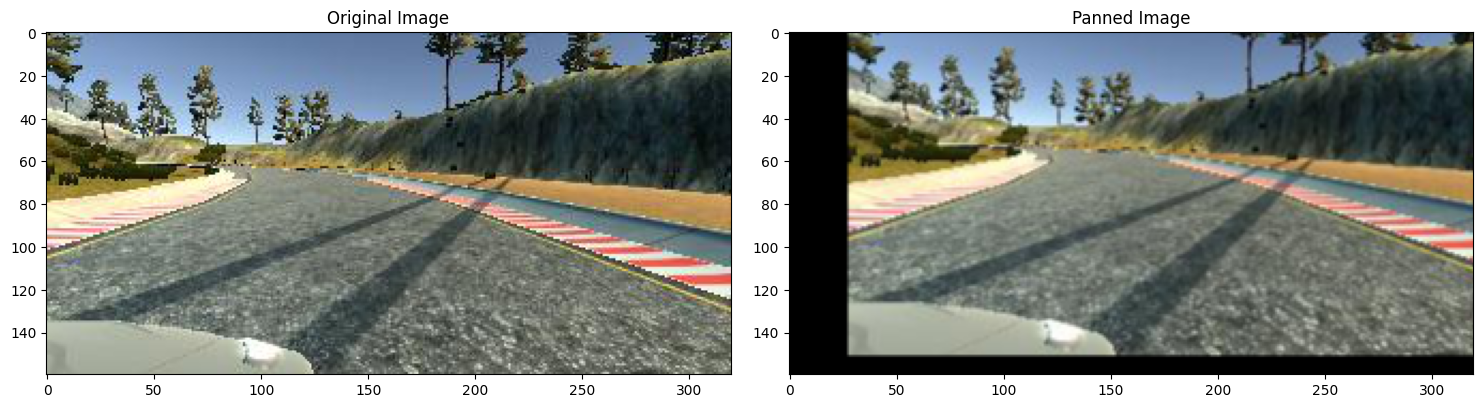

In [ ]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")

Text(0.5, 1.0, 'Brightness altered image ')

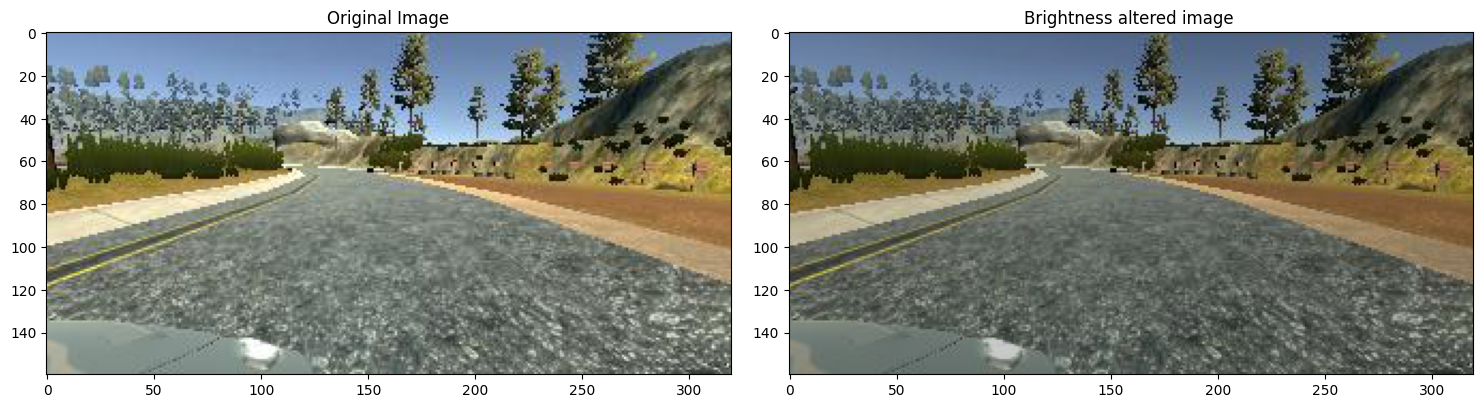

In [ ]:
def random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(brightness_altered_image)
axs[1].set_title("Brightness altered image ")

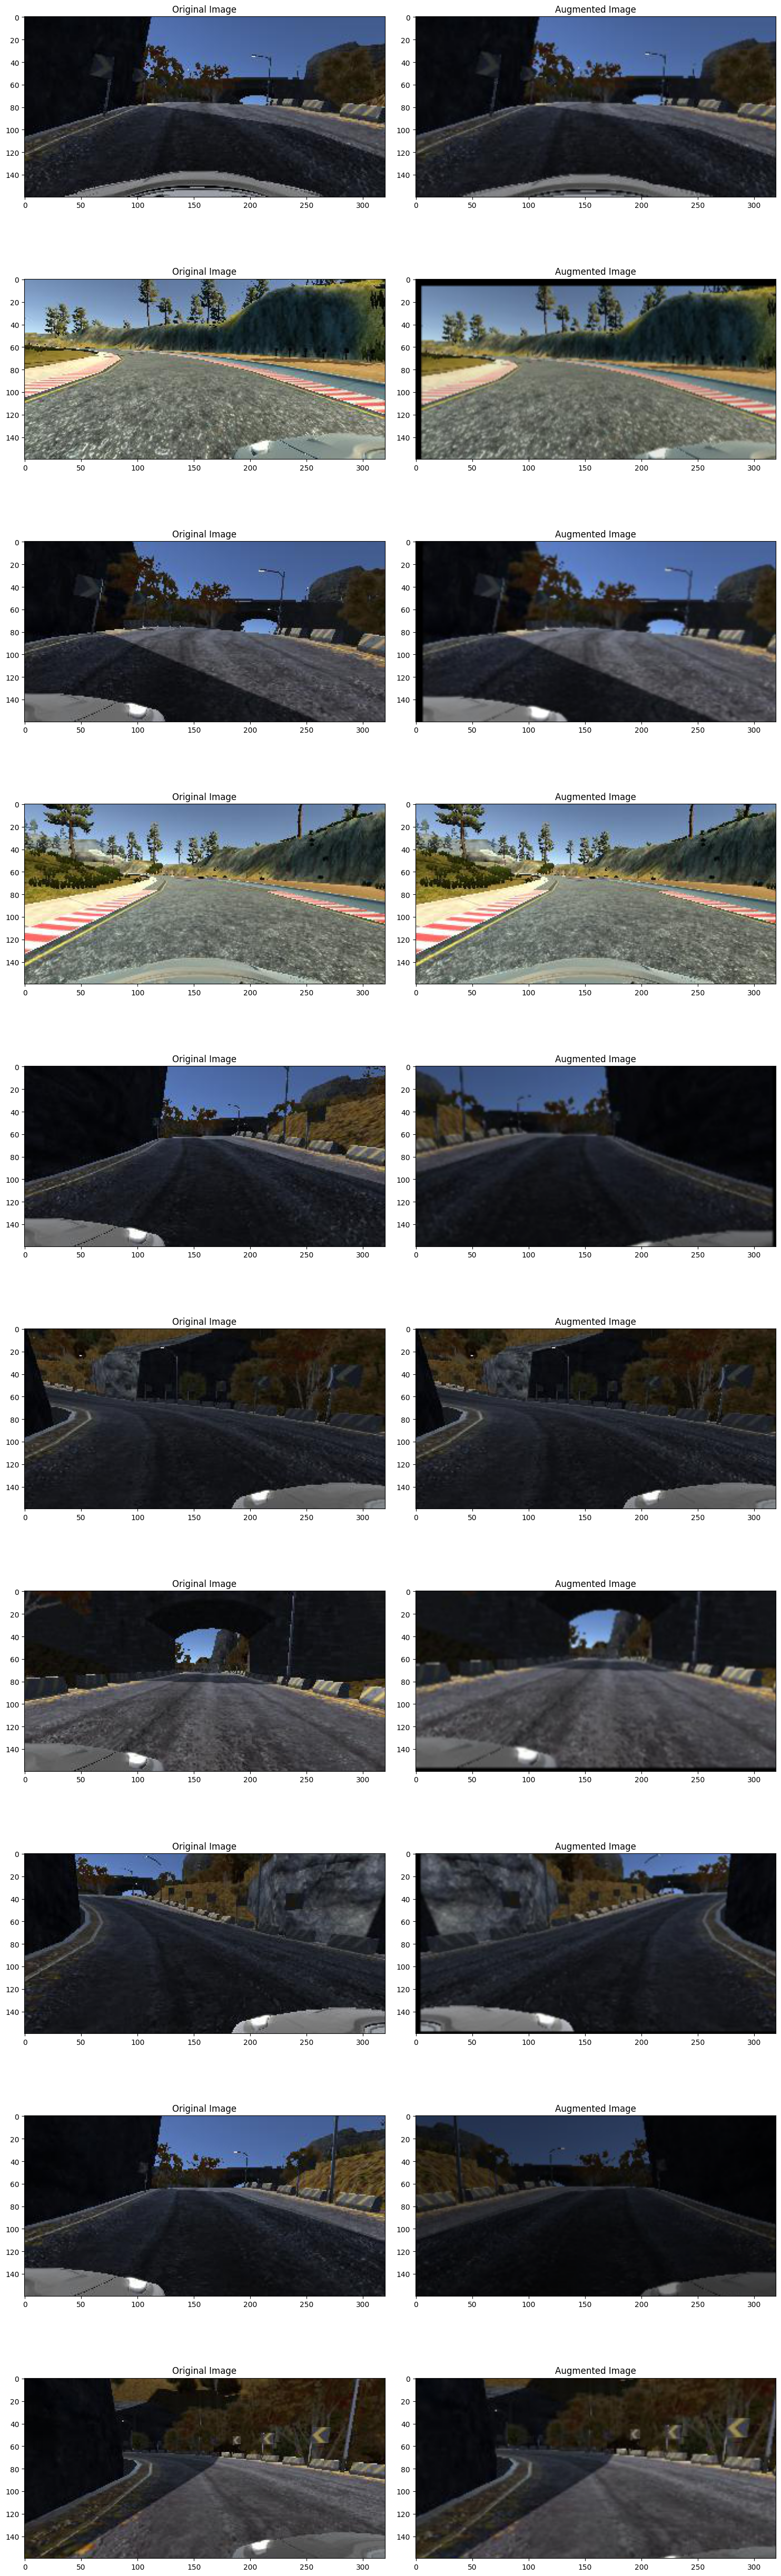

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle

ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [ ]:
def img_preprocess(img):
    ## Crop image to remove unnecessary features
    img = img[60:135, :, :]
    ## Change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    ## Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    ## Decrease size for easier processing
    img = cv2.resize(img, (200, 66))
    ## Normalize values
    img = img / 255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

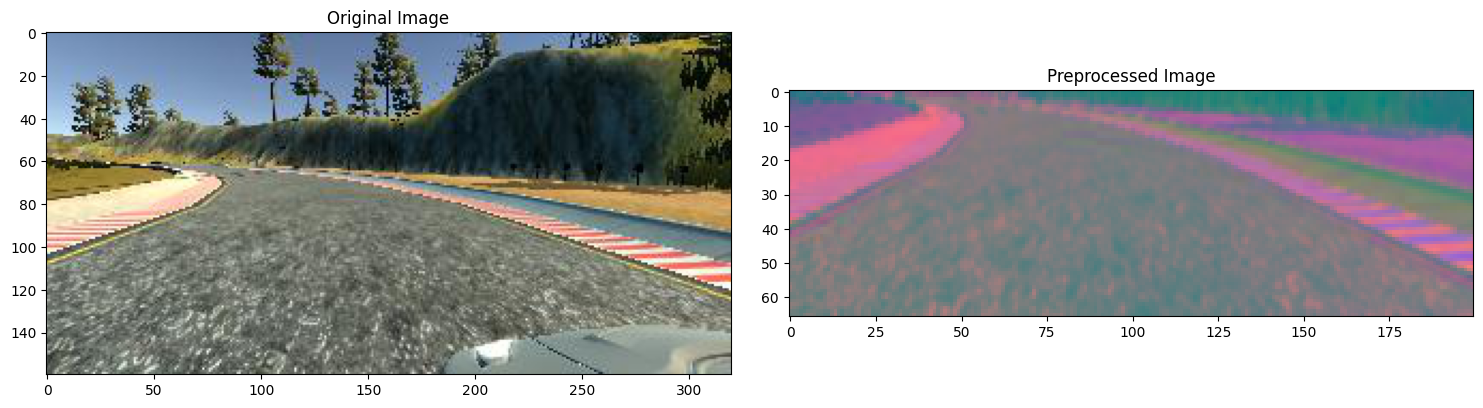

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(
                    image_paths[random_index], steering_ang[random_index]
                )

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

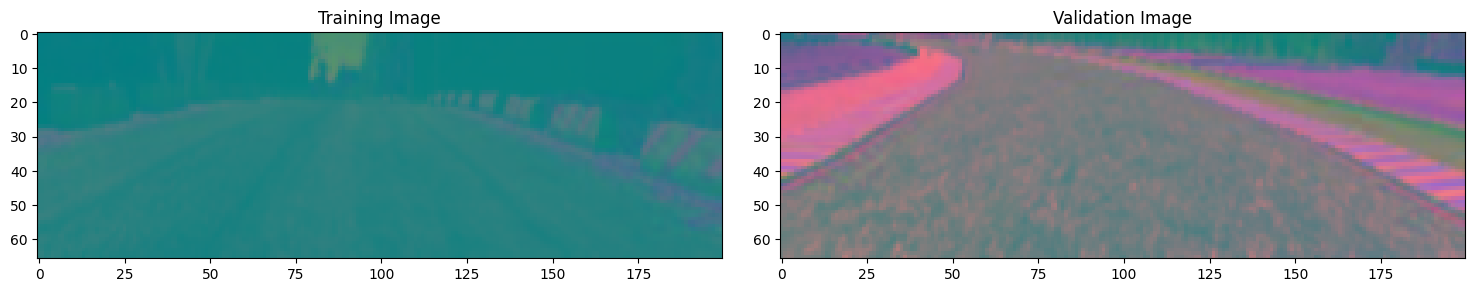

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")

In [ ]:
def NvidiaModel():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu")) 
  model.add(Convolution2D(64,(3,3),activation="elu"))   
  model.add(Convolution2D(64,(3,3),activation="elu"))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer=Adam(lr=1e-3),loss="mse")
  return model

In [ ]:
model = NvidiaModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [ ]:
history = model.fit_generator(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=1,
)

Epoch 1/10
300/300 [==============================] - 528s 2s/step - loss: 0.1335 - val_loss: 0.0969
Epoch 2/10
300/300 [==============================] - 467s 2s/step - loss: 0.1092 - val_loss: 0.0991
Epoch 3/10
300/300 [==============================] - 473s 2s/step - loss: 0.1069 - val_loss: 0.0893
Epoch 4/10
300/300 [==============================] - 527s 2s/step - loss: 0.1048 - val_loss: 0.0929
Epoch 5/10
300/300 [==============================] - 527s 2s/step - loss: 0.1026 - val_loss: 0.0843
Epoch 6/10
300/300 [==============================] - 527s 2s/step - loss: 0.0996 - val_loss: 0.0861
Epoch 7/10
300/300 [==============================] - 525s 2s/step - loss: 0.0996 - val_loss: 0.0855
Epoch 8/10
300/300 [==============================] - 523s 2s/step - loss: 0.0985 - val_loss: 0.0875
Epoch 9/10
300/300 [==============================] - 520s 2s/step - loss: 0.0951 - val_loss: 0.0831
Epoch 10/10
300/300 [==============================] - 517s 2s/step - loss: 0.0962 - val_lo

Text(0.5, 0, 'Epoch')

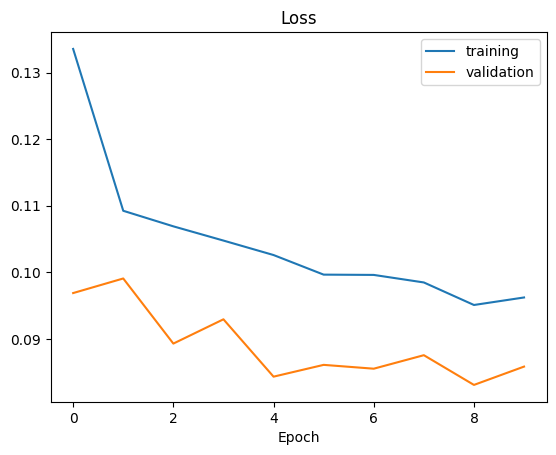

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("Epoch")

In [ ]:
model.save('model.h5')